In [1]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/Utils")


In [2]:
import warnings
import gc
import numpy as np
import pandas as pd
import dask.dataframe as dd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

# Diferenças em Diferenças

### Investigando efeito das políticas estaduais de distribuição de chips e equipamentos frente estados que não realizaram intervenções durante a pandemia

Para calcular o efeito a partir da abordagem de diferenças em diferenças, utilizamos a seguinte equação:

$\hat{y} = \beta_0 + \beta_1 \times Treated + \beta_2 \times Post + \beta_3 \times Treated \times Post + \beta_i \times Cofound_i + ... + \beta_n \times Cofound_n$

Controlando para demais variáveis que produzam impacto no outcome. O efeito obtido então da política será o regressor $\beta_3$.

### Hipótese: 

Políticas de intervenção e subsídio ao acesso de internet amenizaram o impacto negativo do ensino remoto ao fornecer acesso a estudantes vulneráveis.

### Proxy para Tratamento:

Como não existem dados oficiais dos estados sobre a distribuição de chips e equipamentos por escola, utilizamos uma proxy dada pela probabilidade de cada aluno receber chips e equipamentos para cada município.

Essa probabilidade será calculada a partir da seguinte equação:

$E[Chip_ik] = \frac{(\dot{y_i} / n_k)(1 - b)}{a}$

- $E[Chip_i]$ é a probabilidade do aluno $i$ do município $k$ receber um chip/equipamento do governo;
- $\dot{y_i}$ é o número de chips/equipamentos distribuídos para o município $i$;
- $n_k$ é o número de alunos das escolas elegíveis para a política no município $k$;
- $a$ é a probabilidade de erro tipo-I: que o estudante receba acesso a internet mas não seja contabilizado na proxy;
- $b$ é a probabilidade de erro tipo-II: que o estudante não receba acesso a internet mesmo tendo cobertura no município;


# Análise empírica

To-do:

- Coletar informações sobre a distribuição de chips e equipamentos por município com data do início da política e mais detalhes;
- Plotar gráficos com a diferença entre o grupo de controle e de tratamento e a evolução nas notas médias, de português e matemática, de cada grupo no tempo;
- Construir proxy para tratamento;
- Realizar regressão e obter os estimadores de diferenças em diferenças;

In [3]:
from funs import *
from cols_list import cols_enem

## Funções

In [7]:
def agg_home_conditions(df):
    '''
    Cria um índice normalizado que representa a condição de moradia do aluno.
    '''

    mapping = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5}
    cols = ['Q007','Q008','Q009','Q010','Q012','Q014','Q016','Q019']
    for col in cols:
        df[col] = df[col].map(mapping, meta=(col, 'int'))

    series = df['Q007'] + df['Q008'] + \
    df['Q009'] + df['Q010'] + df['Q012'] + \
    df['Q014'] + df['Q016'] + df['Q019'] 
    
    min = series.min().compute()
    max = series.max().compute()

    normalized = series.apply(lambda x: x-min / max-min, meta=series)

    return normalized

In [6]:
def load_and_filter(year):
    '''
    Carrega um ano específico do dataset do ENEM, realiza a 
    filtragem das colunas e insere dados úteis para a análise.
    
    Parameters
    ----------
    year: int
        The year of the data to be loaded

    Returns
    -------
    df: dask.dataframe
        The filtered data
    '''
    cols_to_use = cols_enem + ['Q014', 'Q016', 'NO_MUNICIPIO_ESC']
    enem = filter_enem(dask_load_year_enem(year, cols_to_use), concluinte=True)
    gc.collect()
    enem['Q025'] = enem['Q025'].replace(['A','B'],[0,1])
    enem['NT_MEDIA'] = enem.apply(lambda row: get_medium_score(row), axis=1)
    enem['LOG_NT_MEDIA'] = np.log(enem['NT_MEDIA'])
    enem['LOG_NT_MT'] = np.log(enem['NU_NOTA_MT'])

    try:
        enem['IND_CASA'] = agg_home_conditions(enem)
    except Exception as e:
        print(e)
        print("Error on year {}".format(year))
        raise

    cleared = enem[['NU_ANO','CO_MUNICIPIO_ESC','NO_MUNICIPIO_ESC',
    'SG_UF_ESC','TP_DEPENDENCIA_ADM_ESC', 
    'TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ESTADO_CIVIL',
    'TP_COR_RACA', 'TP_ESCOLA', 'TP_LOCALIZACAO_ESC','LOG_NT_MT','NU_NOTA_LC',
    'NU_NOTA_MT','Q001', 'Q002', 'Q005', 'Q006', 'Q022', 'Q024', 'Q025', 'IND_CASA', 'NT_MEDIA',
    'LOG_NT_MEDIA']]
    
    return cleared

In [9]:
def read_and_label_year(filename):
    df = pd.read_csv(filename, sep=';', encoding='utf-8', dtype={'Valor Transferido':float}, thousands='.',decimal=',')
    df['ANO'] = filename[-8:-4]
    return df

## Processamento e modelagem

In [ ]:
data = dd.concat([load_and_filter(year) for year in range(2018,2022)])

In [ ]:
data = data.compute()

In [8]:
data

,NU_ANO,CO_MUNICIPIO_ESC,NO_MUNICIPIO_ESC,SG_UF_ESC,TP_DEPENDENCIA_ADM_ESC,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_ESCOLA,...,Q001,Q002,Q005,Q006,Q022,Q024,Q025,IND_CASA,NT_MEDIA,LOG_NT_MEDIA
0,2018.0,1500800,Ananindeua,PA,4.0,2.0,F,0.0,4.0,4.0,...,E,E,2.0,F,D,C,1.0,7.794872,503.96,6.222497
1,2018.0,NaN,NaN,NaN,NaN,3.0,F,0.0,4.0,1.0,...,D,E,4.0,B,B,A,0.0,3.794872,468.12,6.148725
2,2018.0,3155603,Rio Pardo de Minas,MG,2.0,3.0,M,0.0,0.0,2.0,...,B,B,7.0,B,D,A,0.0,6.794872,497.84,6.210279
3,2018.0,1500800,Ananindeua,PA,4.0,2.0,F,0.0,3.0,4.0,...,F,F,4.0,I,D,A,1.0,7.794872,675.64,6.515660
5,2018.0,3161106,São Francisco,MG,2.0,2.0,F,0.0,3.0,2.0,...,E,E,3.0,D,D,A,1.0,5.794872,497.78,6.210158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158210,2021.0,1200302,Feijó,AC,2.0,4.0,F,0.0,2.0,2.0,...,B,B,3.0,B,B,A,1.0,3.794872,NaN,NaN
158215,2021.0,3513009,Cotia,SP,2.0,3.0,M,1.0,1.0,2.0,...,E,E,6.0,F,D,A,1.0,7.794872,541.80,6.294897
158218,2021.0,2914703,Itaberaba,BA,2.0,5.0,M,1.0,2.0,2.0,...,H,E,6.0,B,B,B,1.0,8.794872,459.76,6.130705
158220,2021.0,3205002,Serra,ES,1.0,4.0,M,1.0,1.0,2.0,...,G,G,5.0,C,E,C,1.0,5.794872,674.60,6.514120


In [10]:
# persistindo dados para sessão posterior
data.to_parquet('../../Resultados/Agg/ENEM/aux/dados_para_modelagem.parquet')

### Plotando evolução nas notas: controle x tratamento

In [8]:
data.columns

Index(['NU_ANO', 'CO_MUNICIPIO_ESC', 'SG_UF_ESC', 'TP_DEPENDENCIA_ADM_ESC',
       'TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA',
       'TP_ESCOLA', 'TP_LOCALIZACAO_ESC', 'LOG_NT_MT', 'NU_NOTA_LC',
       'NU_NOTA_MT', 'Q001', 'Q002', 'Q005', 'Q006', 'Q022', 'Q024', 'Q025',
       'IND_CASA', 'NT_MEDIA', 'LOG_NT_MEDIA'],
      dtype='object')

In [28]:
a_b = data.query('TP_DEPENDENCIA_ADM_ESC == 2')[['NU_ANO', 'SG_UF_ESC', 'NT_MEDIA', 'LOG_NT_MEDIA','LOG_NT_MT', 'NU_NOTA_MT','NU_NOTA_LC']]

In [29]:
# Comparando grupos de controle e tratametno
a_b = a_b.query('SG_UF_ESC == "PI" or SG_UF_ESC == "CE" or SG_UF_ESC == "BA" or SG_UF_ESC == "MA" or SG_UF_ESC == "PE" or SG_UF_ESC == "RN" or SG_UF_ESC == "SE"')
a_b.reset_index(inplace=True, drop=True)
a_b['NU_ANO'] = a_b['NU_ANO'].astype(int)

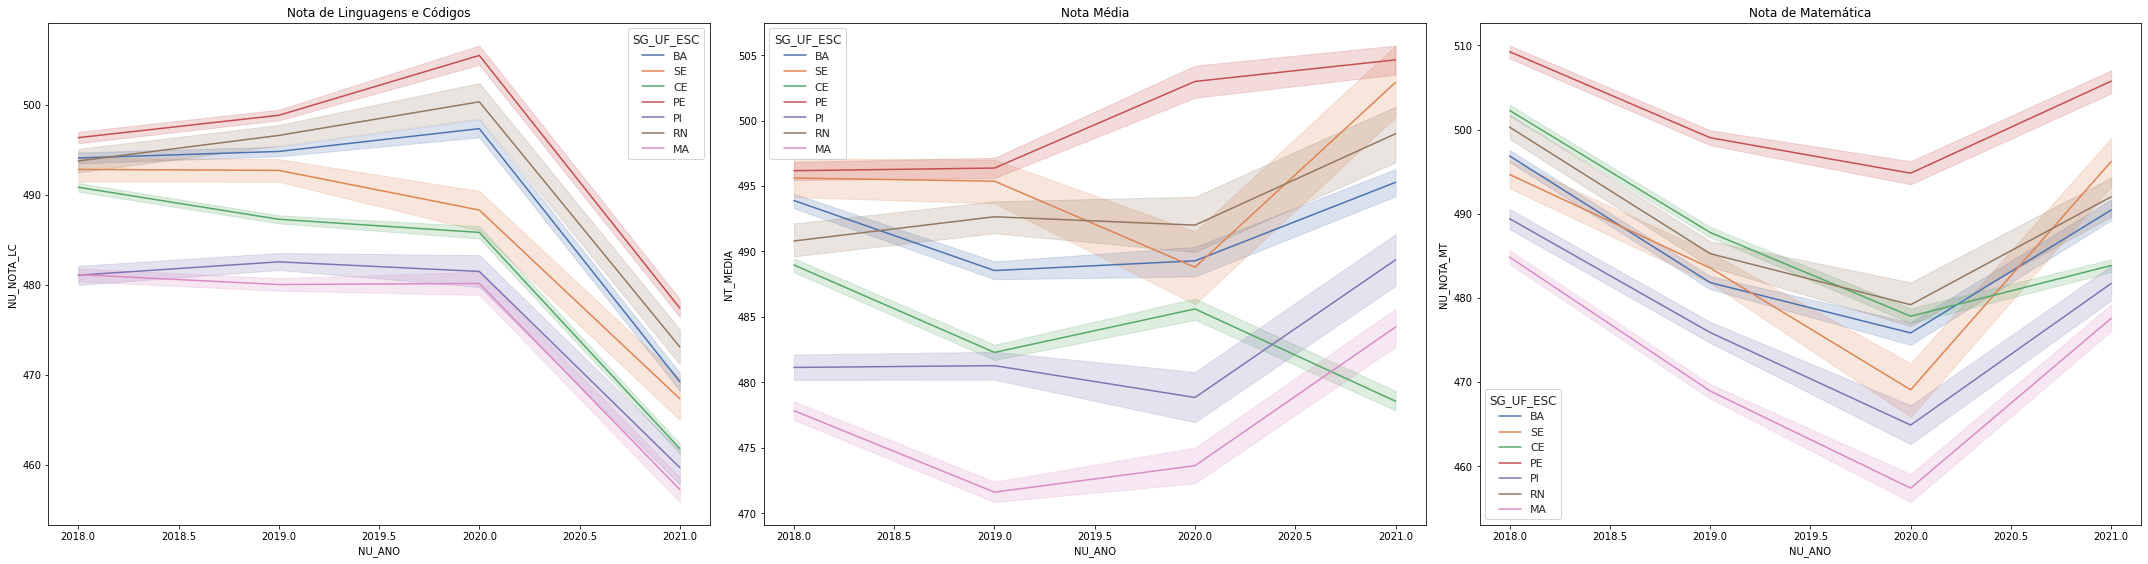

In [30]:
fig, ax = plt.subplots(1,3, figsize=(30, 8))
ax = ax.flatten()
sns.set_theme(style="whitegrid")

ax[0] = sns.lineplot(data=a_b, x='NU_ANO', y='NU_NOTA_LC', hue='SG_UF_ESC', ax=ax[0])
ax[0].set_title('Nota de Linguagens e Códigos')
ax[1] = sns.lineplot(data=a_b, x='NU_ANO', y='NT_MEDIA', hue='SG_UF_ESC', ax=ax[1])
ax[1].set_title('Nota Média')
ax[2] = sns.lineplot(data=a_b, x='NU_ANO', y='NU_NOTA_MT', hue='SG_UF_ESC', ax=ax[2])
ax[2].set_title('Nota de Matemática')

plt.tight_layout()
plt.show()

Sem efeito visual claro nas notas. Porém, isso não é significativo visto que há seleções distintas das amostras

In [31]:
internet = data.query('TP_DEPENDENCIA_ADM_ESC == 2 and TP_LOCALIZACAO_ESC == 1')[['NU_ANO', 'SG_UF_ESC', 'Q025']]
internet = internet.query('SG_UF_ESC == "PI" or SG_UF_ESC == "CE" or SG_UF_ESC == "BA" or SG_UF_ESC == "MA" or SG_UF_ESC == "PE" or SG_UF_ESC == "RN" or SG_UF_ESC == "SE" or SG_UF_ESC == "PA"')
internet.reset_index(inplace=True, drop=True)
internet['NU_ANO'] = internet['NU_ANO'].astype(int)

In [86]:
internet

,NU_ANO,SG_UF_ESC,Q025
0,2018,BA,0.0
1,2018,PA,0.0
2,2018,SE,1.0
3,2018,BA,0.0
4,2018,PA,1.0
...,...,...,...
954596,2021,CE,1.0
954597,2021,BA,1.0
954598,2021,PE,1.0
954599,2021,PE,1.0


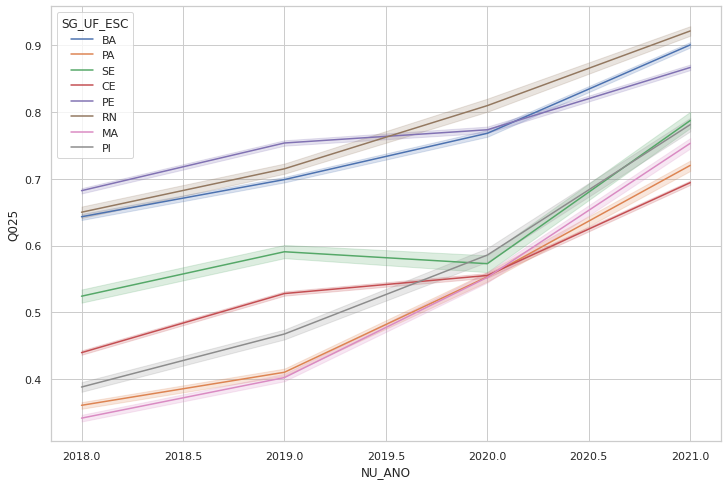

In [32]:
fig = plt.figure(figsize=(12, 8))
sns.lineplot(data=internet, x='NU_ANO', y='Q025', hue='SG_UF_ESC');

É perceptível um aumento mais acentuado no acesso à internet no Maranhão, Piauí e Pará (tratados), constrastando com a tendência da Bahia, Rio Grande do Norte e Pernambuco (não-tratados).

### Ajustes na modelagem

Visualmente, a comparação entre estados com tratamento e sem tratamento não é clara. Porém. podemos realizar o ajuste em regressão para contornar os problemas da seleção amostral por meio do matching e verificar o estimador. 

Outra ideia possível é utilizar o modelo de diferenças em diferenças para estimar o efeito da política na presença de internet em casa. A partir desse estimador obtido, podemos inserir essa variável como instrumento na regressão original para analisar o efeito causal entre presença de internet e notas.

(1):

$Nota_i = \beta_0 + \beta_1 \times Cofound_1 + ... + \beta_n \times Cofound_n  + \mathbf{X_i \times INTERNET_i} + e_i$ 

(2):

$\mathbf{INTERNET_i} = \gamma_0 + \gamma_1 \times Treated + \gamma_2 \times Post + \mathbf{\gamma_3 \times Treated \times Post} +  ... + \gamma_n \times Cofound_n$

## DiDs

Datas das edições do Enem
- 2019: 03/11/2019 e 10/11/2019
- 2020: 17/01/2021 e 24/01/2021  
- 2021: 21/11/2021 e 28/11/2021
- 2022: 13/11/2022 e 20/11/2022

Como estou relacionando política e presença de internet, posso utilizar como tratados os alunos que receberam chips em 2020 já na edição do enem 2020.
Os que receberam chips em janeiro de 2021 não serão considerados como tratados na edição de 2020, pois não houve tempo suficiente para que a distribuição tenha sido concluída. Estes, serão considerados como tratados apenas em 2021.

In [4]:
import statsmodels.api as sm
import glob

In [62]:
# Carregando dataset persistido em outra sessão anterior
data = pd.read_parquet('../../Resultados/Agg/ENEM/aux/dados_para_modelagem.parquet')

In [63]:
# Selecionando escolas públicas estaduais
data = data.query('TP_DEPENDENCIA_ADM_ESC == 2')

# TO-DO: Avaliar estados a serem comparados de acordo com critérios; proximidade geográfica, idh, etc.

data = data[data['SG_UF_ESC'].isin(['PI', 'CE', 'BA', 'MA', 'PE', 'RN', 'SE', 'PA','AL','PA'])]

data['time'] = np.where(

        ((data['SG_UF_ESC'].isin(['MA', 'CE', 'PA'])) & (data['NU_ANO'] > 2019)) 
        |
        ((data['SG_UF_ESC'] == 'PI') & (data['NU_ANO'] > 2020)), 
     1, 
     0)

data['treated'] = np.where(data['SG_UF_ESC'].isin(['MA', 'CE', 'PA', 'PI']), 1, 0)

data['did'] = data['time'] * data['treated']

data['NAO_BRANCO'] = np.where(~data['TP_COR_RACA'].isin([1,4]), 1, 0)

data.Q006 = data.Q006.replace(['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','X','Y','Z'],[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
data.Q006 = data.Q006.fillna(0)
data.IND_CASA = data.IND_CASA.fillna(0)
data.IND_CASA = data.IND_CASA.apply(lambda x: np.round(x, 2))

Carregando a inserindo dados do auxílio emergencial

In [64]:
f = '../../Dados/Auxilio Emerg/beneficio_*.csv'
auxi = pd.concat([read_and_label_year(f) for f in glob.glob(f)])

In [65]:
data.NO_MUNICIPIO_ESC = data.NO_MUNICIPIO_ESC.str.upper()

In [66]:
# Correção de nomes de municípios
auxi['Município'] = auxi['Município'].replace({
    'SANTA ISABEL DO PARÁ':'SANTA IZABEL DO PARÁ',
    'ITAPAGÉ':'ITAPAJÉ',
    'ARAÇAS':'ARAÇÁS',
    'IGUARACI':'IGUARACY',
    'SÃO VICENTE FÉRRER':'SÃO VICENTE FERRER',
    'ELDORADO DOS CARAJÁS':'ELDORADO DO CARAJÁS',
    "OLHO-D'ÁGUA DO BORGES":"OLHO D'ÁGUA DO BORGES",
    'IUIÚ':'IUIU',
    'MUQUÉM DE SÃO FRANCISCO':'MUQUÉM DO SÃO FRANCISCO',
    'ERERÉ':'ERERÊ',
    'AMPARO DO SÃO FRANCISCO':'AMPARO DE SÃO FRANCISCO',
    })
data.NO_MUNICIPIO_ESC = data.NO_MUNICIPIO_ESC.replace({
    'SÃO VICENTE FÉRRER':'SÃO VICENTE FERRER',
    'AMPARO DO SÃO FRANCISCO':'AMPARO DE SÃO FRANCISCO',
    'ERERÉ':'ERERÊ',
    })

In [67]:
data[~data.NO_MUNICIPIO_ESC.isin(auxi['Município'].unique())].NO_MUNICIPIO_ESC.unique()

array(['SERRA CAIADA'], dtype=object)

In [68]:
auxi.rename(columns={'Município':'NO_MUNICIPIO_ESC', 'ANO':'NU_ANO', 'Valor Transferido': 'AUX_EMERG'}, inplace=True)
auxi.NU_ANO = auxi.NU_ANO.astype(int)
merged = pd.merge(data, auxi[['NO_MUNICIPIO_ESC', 'NU_ANO','AUX_EMERG']], on=['NO_MUNICIPIO_ESC', 'NU_ANO'], how='left')

In [69]:
merged.AUX_EMERG = merged.AUX_EMERG.fillna(0)
merged.AUX_EMERG = (merged.AUX_EMERG-merged.AUX_EMERG.min())/(merged.AUX_EMERG.max()-merged.AUX_EMERG.min())

### Propensity Score Matching

In [123]:
# Inserindo partido dos governos estaduais
gov = pd.read_csv('../../Dados/Auxiliares/GovernosEstaduais.csv', decimal=',', thousands='.')
gov.columns = ['UF','SG_UF_ESC','GOV','PARTIDO','PERIODO','NOTAS','INDICE']
gov = gov[['SG_UF_ESC','INDICE']]
#gov = pd.get_dummies(gov, columns=['PARTIDO'], prefix='PARTIDO')

In [125]:
merged = merged.merge(gov, on='SG_UF_ESC', how='left')

In [72]:
# inserindo desempenho no ideb
ideb = pd.read_csv('../../Dados/Auxiliares/idebPorEstado.csv')
merged = merged.merge(ideb, on='SG_UF_ESC', how='left')

In [119]:
# inserindo IDH estadual
idh = pd.read_csv('../../Dados/Auxiliares/idh_estadual_2010_cleaned.csv').rename(columns={'SG_UE':'SG_UF_ESC'})
merged = merged.merge(idh, on='SG_UF_ESC', how='left')

In [73]:
merged.dropna(subset=['Q025'], inplace=True)

In [127]:
idh.columns

Index(['SG_UF_ESC', 'IDHM_RENDA', 'IDHM_LONGEVIDADE', 'IDHM_EDUCACAO'], dtype='object')

In [162]:
y = merged['Q025'].values
d = merged['treated'].values
x = merged[['time', 'treated', 'did', 'NAO_BRANCO', 'IND_CASA', 'Q006', 'AUX_EMERG']]
cofounders = ['NAO_BRANCO', 'IND_CASA', 'Q006', 'AUX_EMERG','NOTA19', 'INDICE','IDHM_RENDA', 'IDHM_LONGEVIDADE', 'IDHM_EDUCACAO']

In [138]:
from causalinference import CausalModel
model = CausalModel(y,d,merged[cofounders].values)

In [139]:
model.est_propensity()

/home/joao/anaconda3/envs/scraping/lib/python3.9/site-packages/causalinference/core/propensity.py:173: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(np.linalg.inv(H)))


In [140]:
print(model.propensity)


Estimated Parameters of Propensity Score

                    Coef.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
     Intercept   -629.409463466079.601     -0.000      1.000-908394145.427908392886.608
            X0      0.474   1973.349      0.000      1.000  -3867.290   3868.238
            X1      0.031    394.644      0.000      1.000   -773.472    773.534
            X2     -0.422    275.496     -0.002      0.999   -540.395    539.552
            X3      1.130  15052.872      0.000      1.000 -29502.498  29504.759
            X4      2.76544492908.633      0.000      1.000-87206098.15587206103.685
            X5     17.497132964661.737      0.000      1.000-260610719.507260610754.501
            X6  -3258.848389119403.661     -0.000      1.000-762677290.024762670772.329
            X7   3262.407546594187.998      0.000      1.000-1071321346.0681071327870.882
            X8    234.454       

In [164]:
x['score'] = model.propensity['fitted']

/tmp/ipykernel_47813/1818189395.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['score'] = model.propensity['fitted']


In [166]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [169]:
model.trim()

ValueError: Too few control units: N_c < K+1

### Executando regressão para presença de internet

In [22]:
print('y:', y.isna().any())
print('x', x.isna().any())

y: False
x time          False
treated       False
did           False
NAO_BRANCO    False
IND_CASA      False
Q006          False
AUX_EMERG     False
dtype: bool


In [23]:
y = y.astype(int)

In [27]:
X = sm.add_constant(x)
est = sm.OLS(y, X)
est2 = est.fit(cov_type='cluster', cov_kwds={'groups':merged['NO_MUNICIPIO_ESC']})
# Robust standard errors: cov_type='HC3'
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                   Q025   R-squared:                       0.204
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     1053.
Date:                Fri, 09 Sep 2022   Prob (F-statistic):               0.00
Time:                        13:20:49   Log-Likelihood:            -6.5060e+05
No. Observations:             1095953   AIC:                         1.301e+06
Df Residuals:                 1095946   BIC:                         1.301e+06
Df Model:                           6                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1842      0.020      8.997      0.0

/home/joao/anaconda3/envs/scraping/lib/python3.9/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 6
  warnings.warn('covariance of constraints does not have full '


### Executando regressão para notas

In [75]:
data2 = data.dropna(subset=['NU_NOTA_MT'])

In [76]:
y = data2['NU_NOTA_MT']
x = data2[['time', 'treated', 'did', 'NAO_BRANCO', 'IND_CASA', 'Q006']]

In [77]:
print('y:', y.isna().any())
print('x', x.isna().any())

y: False
x time          False
treated       False
did           False
NAO_BRANCO    False
IND_CASA      False
Q006          False
dtype: bool


In [78]:
y = y.astype(int)

In [79]:
X = sm.add_constant(x)
est = sm.OLS(y, X)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:             NU_NOTA_MT   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     8377.
Date:                Thu, 08 Sep 2022   Prob (F-statistic):               0.00
Time:                        10:16:13   Log-Likelihood:            -4.4857e+06
No. Observations:              769620   AIC:                         8.971e+06
Df Residuals:                  769614   BIC:                         8.971e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        460.5205      0.391   1178.609      0.0